In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

In [2]:
test=pd.read_csv("test_loan.csv")
train=pd.read_csv("train_loan.csv")

In [3]:
#Check columns
train.columns

Index([u'Loan_ID', u'Gender', u'Married', u'Dependents', u'Education',
       u'Self_Employed', u'ApplicantIncome', u'CoapplicantIncome',
       u'LoanAmount', u'Loan_Amount_Term', u'Credit_History', u'Property_Area',
       u'Loan_Status'],
      dtype='object')

In [4]:
#Check data types
train.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [5]:
#Proportion of Yes/No in the training data
train["Loan_Status"].value_counts(normalize=True)

Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64

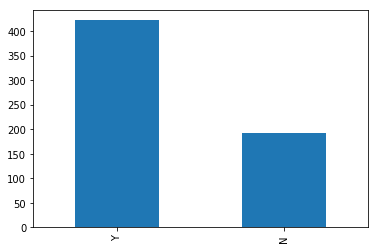

In [6]:
train["Loan_Status"].value_counts().plot.bar()

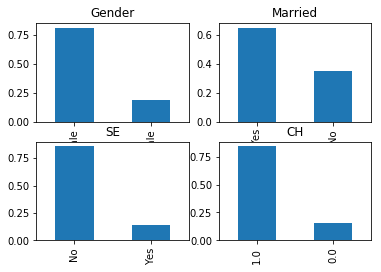

In [7]:
#Proportions of accepted/rejected loans for categories

plt.subplot(221)
train["Gender"].value_counts(normalize=True).plot.bar(title="Gender")
plt.subplot(222)
train["Married"].value_counts(normalize=True).plot.bar(title="Married")
plt.subplot(223)
train["Self_Employed"].value_counts(normalize=True).plot.bar(title="SE")
plt.subplot(224)
train["Credit_History"].value_counts(normalize=True).plot.bar(title="CH")

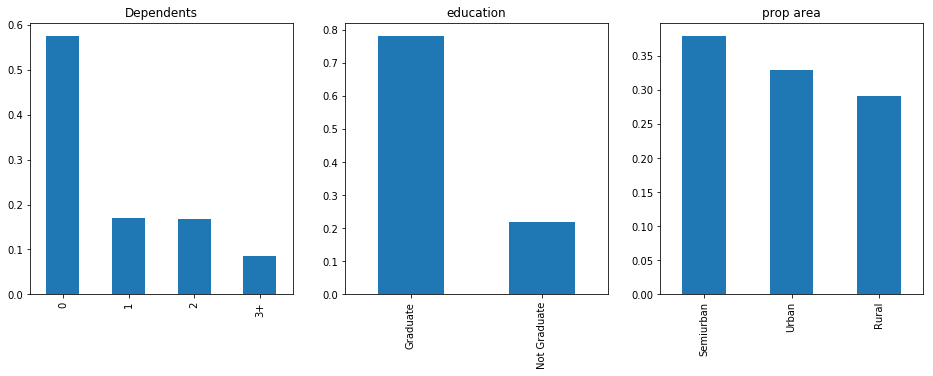

In [8]:
#General summary of dependents, education, and property area
plt.subplot(131)
train["Dependents"].value_counts(normalize=True).plot.bar(figsize=(16,5),title="Dependents")
plt.subplot(132)
train["Education"].value_counts(normalize=True).plot.bar(title="education")
plt.subplot(133)
train["Property_Area"].value_counts(normalize=True).plot.bar(title="prop area")

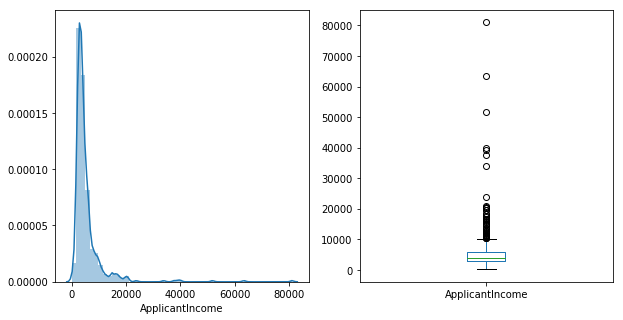

In [9]:
#Quick visualization of Applicant Income. As expected, it is skewed right.
plt.subplot(121)
sns.distplot(train["ApplicantIncome"])
plt.subplot(122)
train["ApplicantIncome"].plot.box(figsize=(10,5))

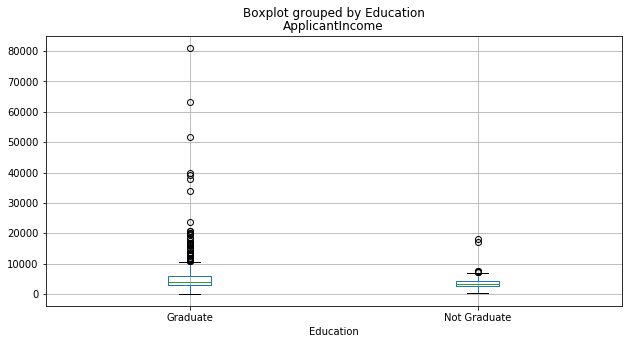

In [10]:
#Visualization of applicant income based on education level. 
#As expected, applicants with the highest income tend to be college graduates.
train.boxplot(column="ApplicantIncome",by="Education", figsize=(10,5))

In [11]:
#We will now look at categorical independent variables vs. the target variable (loan status)

In [12]:
#We start by gender:
gender = pd.crosstab(train["Gender"],train["Loan_Status"])
gender.head(2)
gender2=gender.div(gender.sum(1),axis=0)
gender2.head(2)

Loan_Status,N,Y
Gender,,
Female,0.330357,0.669643
Male,0.306748,0.693252


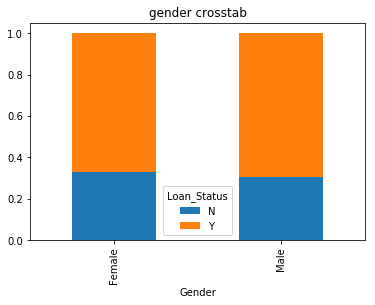

In [13]:
#We can see that roughly the same proportion of males and females get accepted/denied for a loan.
gender2.plot.bar(stacked=True,title="gender crosstab")

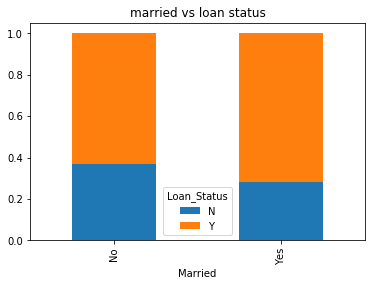

In [14]:
#Quick analysis of loan status vs. marriage status. 
#The accepted proportion is slightly higher for married couples
married=pd.crosstab(train["Married"],train["Loan_Status"])
married.div(married.sum(1),axis=0).plot.bar(stacked=True,title="married vs loan status")

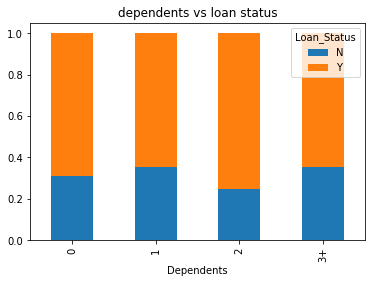

In [15]:
#Do the same for number of dependents:
dependents=pd.crosstab(train["Dependents"],train["Loan_Status"])
dependents.div(dependents.sum(1),axis=0).plot.bar(stacked=True,title="dependents vs loan status")

In [16]:
#We can see that gender, marriage status, and number of dependents does not really affect whether someone is
#eligible for a loan or not.


In [17]:
#Numerical Independent Variable vs Target Variable (loan status)

In [18]:
income=train.groupby("Loan_Status")["ApplicantIncome"].mean()
income.head(4)
train["ApplicantIncome"].max()
#This is the maximum income of all applicants

81000

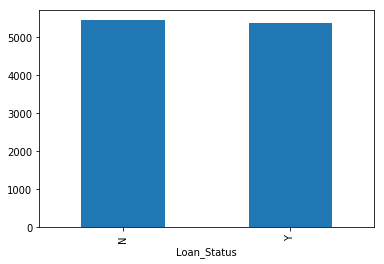

In [19]:
income.plot.bar()

#Here the y-axis represents the mean applicant income. 
#We don’t see any change in the mean income. 
#We can make bins for the applicant income variable based on the values in it 
#and analyze the corresponding loan status for each bin.

In [20]:
binss=[0,2500,4000,6000,81000] 
groups=['Low','Average','High', 'Very high'] 
train["incomebin"]=pd.cut(train['ApplicantIncome'],binss,labels=groups)


income_bin=pd.crosstab(train["incomebin"],train["Loan_Status"])

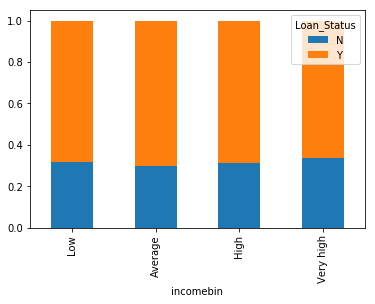

In [21]:
income_bin.div(income_bin.sum(1),axis=0).plot.bar(stacked=True)


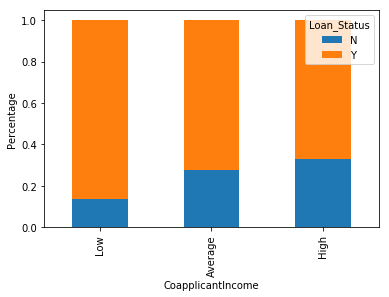

In [22]:
#We can make a similar visualization on the total income of applicants
bins=[0,1000,3000,42000] 
group=['Low','Average','High'] 
train['Coapplicant_Income_bin']=pd.cut(train['CoapplicantIncome'],bins,labels=group)
Coapplicant_Income_bin=pd.crosstab(train['Coapplicant_Income_bin'],train['Loan_Status'])
Coapplicant_Income_bin.div(Coapplicant_Income_bin.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.xlabel('CoapplicantIncome') 
P = plt.ylabel('Percentage')

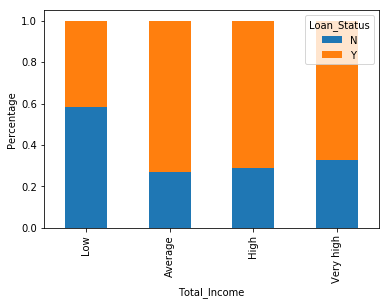

In [23]:
#Do the same for total income (combinining the income plots)
train['Total_Income']=train['ApplicantIncome']+train['CoapplicantIncome']
bins=[0,2500,4000,6000,81000] 
group=['Low','Average','High', 'Very high'] 
train['Total_Income_bin']=pd.cut(train['Total_Income'],bins,labels=group)
Total_Income_bin=pd.crosstab(train['Total_Income_bin'],train['Loan_Status']) 
Total_Income_bin.div(Total_Income_bin.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True) 
plt.xlabel('Total_Income') 
P = plt.ylabel('Percentage')
#Now, we can see that there is indeed a difference between income level and loan status

In [24]:
#Visualization on loan amount / Loan Status

bins = [0,100,200,700]
groups = ["low","average","high"]
train["loanamountbin"]=pd.cut(train["LoanAmount"],bins,labels=groups)

In [25]:
loanamountbin=pd.crosstab(train["loanamountbin"],train["Loan_Status"])

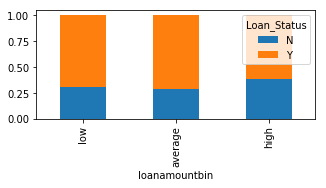

In [26]:
loanamountbin.div(loanamountbin.sum(1),axis=0).plot.bar(stacked=True,figsize=(5,2))
#The loan approval rate is higher for smaller loans than large ones.

In [27]:
#Dropping the columns we used for exploratory data analysis. 
train2=train.drop(["incomebin","Coapplicant_Income_bin","loanamountbin","Total_Income_bin","Total_Income"],axis=1)



In [28]:
#We want to change "Dependents" into a numeric variable, so we replace 3+ with 3
train2["Dependents"].replace("3+",3,inplace=True)

In [29]:
test['Dependents'].replace('3+', 3,inplace=True)

In [30]:
#To run prediction models, we need to tabulate Yes/No as 1/0.
train2.replace("Y",1,inplace=True)
train2.replace("N",0,inplace=True)


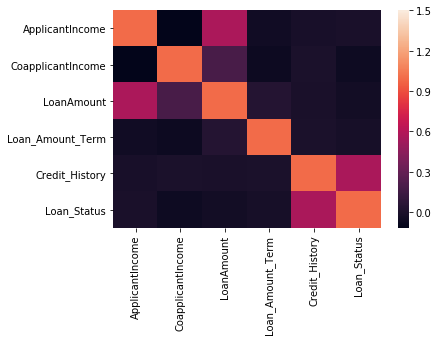

In [31]:
#Heat map of the variables
matrix = train2.corr()
sns.heatmap(matrix,vmax=1.5,square=False)


#The most correlated variables are:
#Applicant Income - Loan Amount
#Credit History - Loan Status
#Coapplicant Income - Loan Amount (slight correlation)

In [32]:
#Before data analysis, we must treat missing data and outliers.

#We can use mode data to fill missing data for categorical variables (imputation by mode)
#For numeric variables, it is better to use the median or mean to impute missing values
train2["Gender"].fillna(train["Gender"].mode()[0],inplace=True)
train2["Married"].fillna(train2["Married"].mode()[0],inplace=True)
train2["Dependents"].fillna(train2["Dependents"].mode()[0],inplace=True)
train2["Credit_History"].fillna(train2["Credit_History"].mode()[0],inplace=True)
train2["Self_Employed"].fillna(train2["Self_Employed"].mode()[0],inplace=True)
train2["Loan_Amount_Term"].fillna(train2["Loan_Amount_Term"].mode()[0],inplace=True)
train2["LoanAmount"].fillna(train2["LoanAmount"].median(),inplace=True)


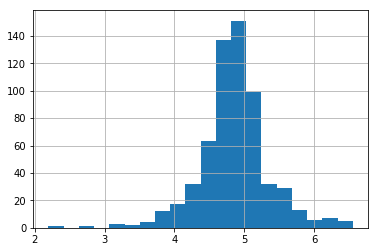

In [33]:
#The loan amount variable has many outliers (shown earlier). The data is skewed-right. 
#We can remove the skewedness by utilizing a log transformation.

train2.isnull().sum()
train2["LoanAmountLog"]=np.log(train2["LoanAmount"])
test['LoanAmountlog'] = np.log(test['LoanAmount'])
train2["LoanAmountLog"].hist(bins=20)


In [34]:
#SKlearn needs the target variable in a separate dataset. 
#We can do this by dropping the Loan Status column and putting it in another dataframe (y).

train2=train2.drop('Loan_ID',axis=1) 
test=test.drop('Loan_ID',axis=1)


x = train2.drop("Loan_Status",1)
train2.isnull().sum()
train2.fillna(train2["LoanAmountLog"].mean(),inplace=True)
y=train2["Loan_Status"]

In [36]:
#We need to transform the gender 

#Once we apply dummies to this variable, it will convert the “Gender” variable into two variables
#(Gender_Male and Gender_Female), one for each class, i.e. Male and Female.
#Gender_Male will have a value of 0 if the gender is Female and a value of 1 if the gender is Male.
x=pd.get_dummies(x)
train2=pd.get_dummies(train2)
test=pd.get_dummies(test)



#We can divide our data set using train test split.
#This divides the data into a training and validation portion
xtrain, xcv, ytrain, ycv = train_test_split(x,y, test_size=.3)

In [70]:
#Using the Logistic Regression Model:
model = LogisticRegression()


#Specifications of the regression model:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,          
                   intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,          
                   penalty='l2', random_state=1, solver='liblinear', tol=0.0001,          
                   verbose=0, warm_start=False)

#Here the C parameter represents inverse of regularization strength. 
#Regularization is applying a penalty to increasing the magnitude of parameter values in order to reduce overfitting. 
#Smaller values of C specify stronger regularization

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [71]:
model.fit(xtrain,ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [88]:
#Let’s predict the Loan_Status for validation set and calculate its accuracy.

predcv=model.predict(xcv)
accuracy_score(ycv,predcv)
#Our predictions are 80% accurate



0.8

In [76]:
#test["LoanAmountlog"].fillna(test["LoanAmountlog"].mean(),inplace=True)
#test["Credit_History"].fillna(test["Credit_History"].mode()[0],inplace=True)

#test["Loan_Amount_Term"].fillna(test["Loan_Amount_Term"].mode()[0],inplace=True)
#test["LoanAmount"].fillna(test["LoanAmount"].median(),inplace=True)

In [87]:
test = test.drop(["TotalIncome","TotalIncomeLog"],1) #We have to drop the extra columns in the testing data first
predtest=model.predict(test)

#These are predictions for the testing dataset

In [90]:

#Import the submission file to check the prediction.
submission=pd.read_csv("sample_submission.csv")

In [91]:
testoriginal=pd.read_csv("test_loan.csv") #this is the original dataset without any manipulation

submission["Loan_Status"]=predtest
submission['Loan_ID']=testoriginal['Loan_ID']
submission #We create a dataframe with Loan ID and Loan Status to compare results with

,Loan_ID,Loan_Status
0,LP001015,1
1,LP001022,1
2,LP001031,1
3,LP001035,1
4,LP001051,1
5,LP001054,1
6,LP001055,1
7,LP001056,0
8,LP001059,1
9,LP001067,1


In [102]:
#convert 1 and 0 to Yes and No
submission['Loan_Status'].replace(0, 'N',inplace=True) 
submission['Loan_Status'].replace(1, 'Y',inplace=True)

#If we compare this to our testing data, we get an accuracy of .785 (close to cross-validation result)




(367, 21)

In [101]:
predtest.shape

(367L,)

In [47]:
i=1
kf=StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
for train_index,test2_index in kf.split(x,y):
    print ("\n{} of kfold {}".format(i,kf.n_splits))
    xtr,xvl=x.loc[train_index],x.loc[test2_index]
    ytr,yvl = y.loc[train_index],y.loc[test2_index]
    model=LogisticRegression(random_state=1)
    model.fit(xtr,ytr)
    pred_test=model.predict(xvl)
    score=accuracy_score(yvl,pred_test)
    print ("accuracy score", score)
    i+=1
pred_test = model.predict(test)
pred=model.predict_proba(xvl)[:,1]


1 of kfold 5
('accuracy score', 0.7983870967741935)

2 of kfold 5
('accuracy score', 0.8306451612903226)

3 of kfold 5
('accuracy score', 0.8114754098360656)

4 of kfold 5
('accuracy score', 0.7950819672131147)

5 of kfold 5
('accuracy score', 0.8278688524590164)


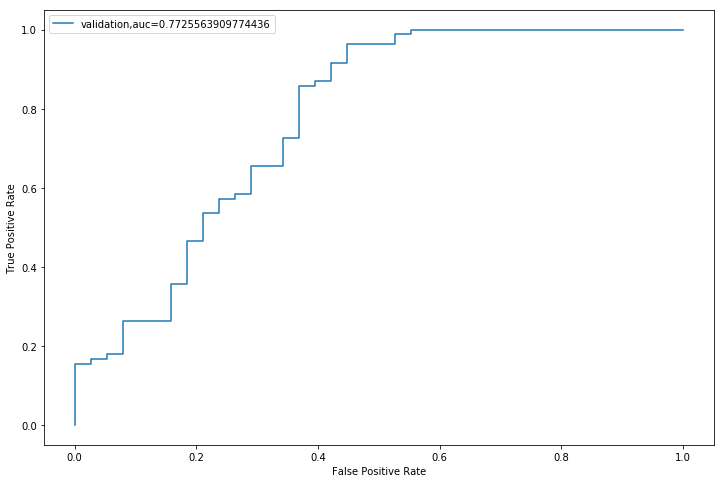

In [50]:
fpr,tpr, _= metrics.roc_curve(yvl,pred)
auc = metrics.roc_auc_score(yvl,pred)
plt.figure (figsize=(12,8))
plt.plot(fpr,tpr,label="validation,auc=" + str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=2)
plt.show()

In [51]:
train2["TotalIncome"]=train2["ApplicantIncome"]+train2["CoapplicantIncome"]

In [52]:
test["TotalIncome"]=test["ApplicantIncome"]+test["CoapplicantIncome"]

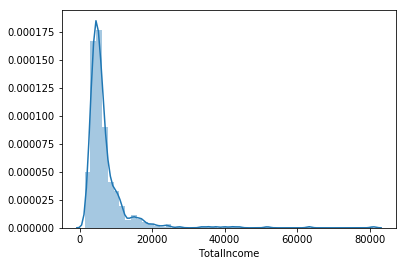

In [53]:
sns.distplot(train2["TotalIncome"])

In [54]:
train2["TotalIncomeLog"]=np.log(train2["TotalIncome"])
test["TotalIncomeLog"]=np.log(test["TotalIncome"])

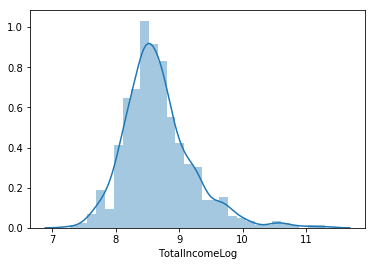

In [55]:
sns.distplot(train2["TotalIncomeLog"])

In [103]:
#train2.drop(["ApplicantIncome","CoapplicantIncome","LoanAmount","Loan_Amount_Term",],axis=1)

In [104]:
#test.drop(["ApplicantIncome","CoapplicantIncome","LoanAmount","Loan_Amount_Term"],axis=1)

In [58]:
X=train2.drop("Loan_Status",axis=1)

In [59]:
Y=train2[("Loan_Status")]

In [60]:
i=1 
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True) 
for train_index,test_index in kf.split(X,Y):   
    print('\n{} of kfold {}'.format(i,kf.n_splits))     
    xtr,xvl = X.loc[train_index],X.loc[test_index]     
    ytr,yvl = Y[train_index],Y[test_index]
    model = LogisticRegression(random_state=1)     
    model.fit(xtr, ytr)     
    pred_test = model.predict(xvl)     
    score = accuracy_score(yvl,pred_test)     
    print('accuracy_score',score)     
    i+=1 
pred_test = model.predict(test) 
pred=model.predict_proba(xvl)[:,1]



1 of kfold 5
('accuracy_score', 0.7983870967741935)

2 of kfold 5
('accuracy_score', 0.8306451612903226)

3 of kfold 5
('accuracy_score', 0.8114754098360656)

4 of kfold 5
('accuracy_score', 0.7950819672131147)

5 of kfold 5
('accuracy_score', 0.8278688524590164)


In [61]:
i=1
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
for train_index, test_index in kf.split(X,Y):
    print ("\n{} of kfold {}".format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = Y.loc[train_index],Y.loc[test_index]
    model = tree.DecisionTreeClassifier(random_state=1)
    model.fit(xtr,ytr)
    pred_test = model.predict(xvl)
    score=accuracy_score(yvl,pred_test)
    print ("accuracy score",score)
    i+=1



1 of kfold 5
('accuracy score', 0.6774193548387096)

2 of kfold 5
('accuracy score', 0.7258064516129032)

3 of kfold 5
('accuracy score', 0.7131147540983607)

4 of kfold 5
('accuracy score', 0.7131147540983607)

5 of kfold 5
('accuracy score', 0.7295081967213115)


In [62]:
i=1
kf=StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
for train_index,test_index in kf.split(X,Y):
    print ("\n{} of kfold {}".format(i,kf.n_splits))
    xtr,xvl= X.loc[train_index],X.loc[test_index]
    ytr,yvl = Y.loc[train_index],Y.loc[test_index]
    model=RandomForestClassifier(random_state=1,max_depth=10)
    model.fit(xtr,ytr)
    pred_test=model.predict(xvl)
    score=accuracy_score(yvl,pred_test)
    print ("accuracy_score",score)
    i+=1


1 of kfold 5
('accuracy_score', 0.7903225806451613)

2 of kfold 5
('accuracy_score', 0.8064516129032258)

3 of kfold 5


C:\Users\Elliot\Anaconda2\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


('accuracy_score', 0.7295081967213115)

4 of kfold 5
('accuracy_score', 0.7622950819672131)

5 of kfold 5
('accuracy_score', 0.7868852459016393)


In [63]:
from sklearn.model_selection import GridSearchCV
paramgrid = {'max_depth': list(range(1, 20, 2)), 'n_estimators': list(range(1, 200, 20))}
grid_search=GridSearchCV(RandomForestClassifier(random_state=1),paramgrid)
x_train, x_cv, y_train, y_cv = train_test_split(X,y, test_size =0.3, random_state=1)
# Fit the grid search model 
grid_search.fit(x_train,y_train)
GridSearchCV(cv=None, error_score='raise',estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\
max_depth=None, max_features='auto', max_leaf_nodes=None,min_impurity_decrease=0.0, min_impurity_split=None,min_samples_leaf=1,\
min_samples_split=2,min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,oob_score=False, random_state=1, verbose=0, warm_start=False),fit_params=None, iid=True, n_jobs=1, \
param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],'n_estimators': [1, 21, 41, 61,81, 101, 121, 141, 161, 181]},pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',scoring=None, verbose=0)

C:\Users\Elliot\Anaconda2\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Elliot\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 21, 41, 61, 81, 101, 121, 141, 161, 181], 'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

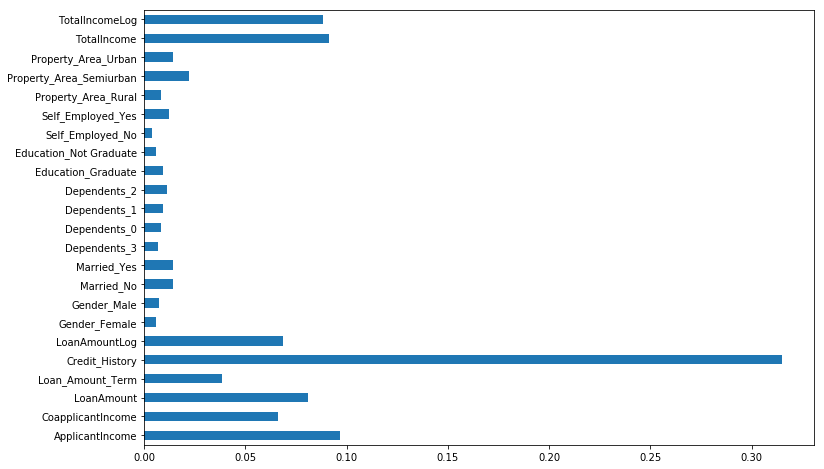

In [64]:
importances=pd.Series(model.feature_importances_, index=X.columns)
importances.plot(kind='barh', figsize=(12,8))

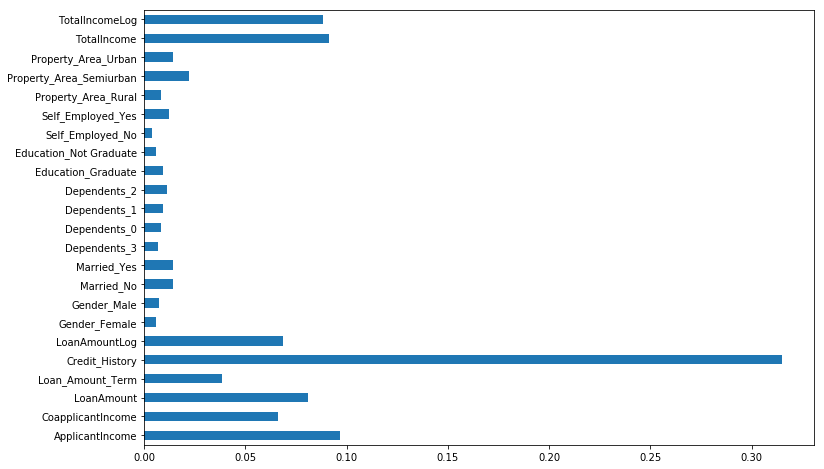

In [65]:
importances.plot(kind='barh', figsize=(12,8))

In [66]:
from xgboost import XGBClassifier

In [67]:
i=1
kf=StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
for train_index, test_index in kf.split(X,Y):
    print ("\n {} of kfold {}".format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl= Y.loc[train_index],Y.loc[test_index]
    model=XGBClassifier(n_estimators=50,max_depth=4)
    model.fit(xtr,ytr)
    pred_test = model.predict(xvl)
    score = accuracy_score(yvl,pred_test)
    print('accuracy_score',score)
    i+=1
pred_test = model.predict(test) 
pred3=model.predict_proba(test)[:,1]


 1 of kfold 5
('accuracy_score', 0.782258064516129)

 2 of kfold 5
('accuracy_score', 0.8145161290322581)

 3 of kfold 5
('accuracy_score', 0.7622950819672131)

 4 of kfold 5
('accuracy_score', 0.7868852459016393)

 5 of kfold 5
('accuracy_score', 0.8360655737704918)


ValueError: feature_names mismatch: [u'ApplicantIncome', u'CoapplicantIncome', u'LoanAmount', u'Loan_Amount_Term', u'Credit_History', u'LoanAmountLog', u'Gender_Female', u'Gender_Male', u'Married_No', u'Married_Yes', u'Dependents_3', u'Dependents_0', u'Dependents_1', u'Dependents_2', u'Education_Graduate', u'Education_Not Graduate', u'Self_Employed_No', u'Self_Employed_Yes', u'Property_Area_Rural', u'Property_Area_Semiurban', u'Property_Area_Urban', u'TotalIncome', u'TotalIncomeLog'] [u'ApplicantIncome', u'CoapplicantIncome', u'LoanAmount', u'Loan_Amount_Term', u'Credit_History', u'LoanAmountlog', u'Gender_Female', u'Gender_Male', u'Married_No', u'Married_Yes', u'Dependents_3', u'Dependents_0', u'Dependents_1', u'Dependents_2', u'Education_Graduate', u'Education_Not Graduate', u'Self_Employed_No', u'Self_Employed_Yes', u'Property_Area_Rural', u'Property_Area_Semiurban', u'Property_Area_Urban', u'TotalIncome', u'TotalIncomeLog']
expected LoanAmountLog in input data
training data did not have the following fields: LoanAmountlog